In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

data = pd.read_csv("data/train_clean.csv")
data.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


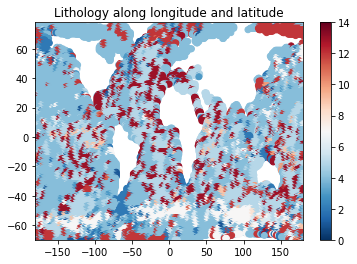

In [2]:
lon = data["longitude"].values
lat = data["latitude"].values
y = data["lithology"].values


# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="RdBu_r", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.colorbar(sc)
    plt.show()

draw_global(lon, lat, y, "Lithology along longitude and latitude")

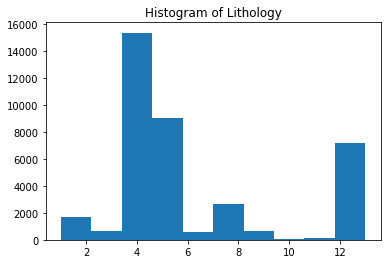

Unique class = [ 1  2  3  4  5  6  7  8  9 10 11 12 13]


In [3]:
# plot the histogram of lithology
plt.hist(y)
plt.title("Histogram of Lithology")
plt.show()
print("Unique class = {}".format(np.unique(y)))

### One-vs-all

Build 13 classifier such that

$$h_\theta^{(i)}(x) = P(y=i|x; \theta) \quad (i=1, 2, ..., 13)$$

Train a logistic regression classifier $h_\theta^{(i)}(x)$ for each class $i$ to predict the probability that $y=i$.

On a new input $x$, to make a prediction, pick the class i that maximizes
$$max_{i} h_\theta^{(i)}(x)$$

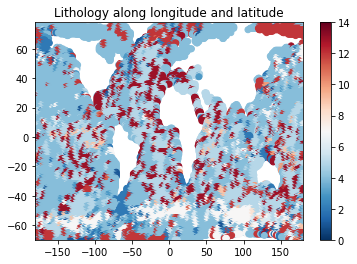

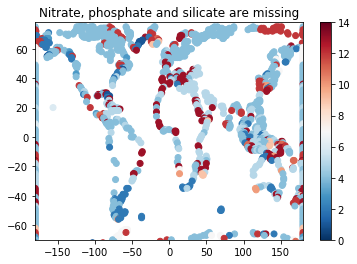

In [4]:
# training data should exclude longitude and latitude
training_data = data.copy()
del training_data["longitude"]
del training_data["latitude"]
training_data.head()

# feature missing reports
# for col in training_data:
#     missing = sum(pd.isnull(training_data[col]))
#     print("Missing Count in {} = {}".format(col, missing))
    

# check missing are consistent
nitrate_missing = pd.isnull(training_data["nitrate"])
phosphate_missing = pd.isnull(training_data["phosphate"])
silicate_missing = pd.isnull(training_data["silicate"])
assert np.array_equal(nitrate_missing, phosphate_missing)
assert np.array_equal(nitrate_missing, silicate_missing)


# global map including and excluding missing parts
draw_global(lon, lat, y, "Lithology along longitude and latitude")
# highlight place of missing
draw_global(lon[nitrate_missing],
            lat[nitrate_missing],
            y[nitrate_missing], 
            "Nitrate, phosphate and silicate are missing")

In [5]:
# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# construct X and y 
X = training_data[features].as_matrix()
y = training_data[target].as_matrix()

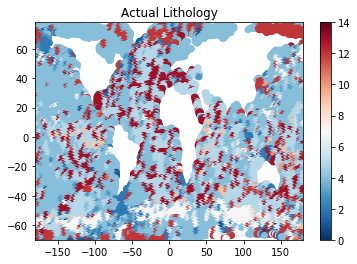

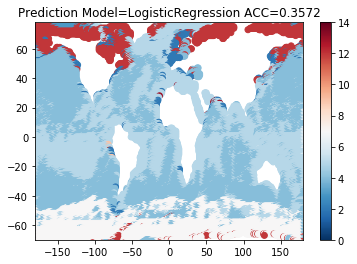

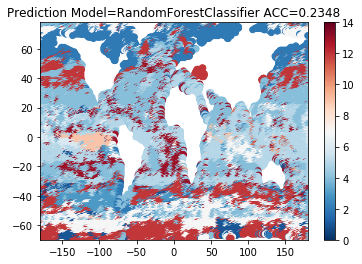

In [6]:
# import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# import sklearn preprocessing and validation
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, Imputer

def validate(X, y, classifier, name):
    """Validate with given classifier."""
    # standardize X
    X = StandardScaler().fit_transform(X)
    # cross validation and obtain prediction
    prediction = cross_val_predict(classifier, X, y, cv=3)
    acc = round(accuracy_score(y, prediction), 4)
    title = "Prediction Model={} ACC={}".format(name, acc)
    draw_global(lon, lat, prediction, title)

# different classifiers
logistic = LogisticRegression()
rfc = RandomForestClassifier()
gpc = GaussianProcessClassifier()

# cross validation
draw_global(lon, lat, y, "Actual Lithology")
validate(X, y, logistic, "LogisticRegression")
validate(X, y, rfc, "RandomForestClassifier")
# validate(gpc, "GaussianProcess")

In [7]:
# use aboleth
import logging
import tensorflow as tf
import aboleth as ab

# Set up a python logger so we can see the output of MonitoredTrainingSession
logger = logging.getLogger()
logger.setLevel(logging.INFO)

RSEED = 0
ab.set_hyperseed(RSEED)
FRAC_TEST = 0.1
NEPOCHS = 5  # number of times to see the data in training
BSIZE = 100  # mini batch size
CONFIG = tf.ConfigProto(device_count={'GPU': 0})
LSAMPLES = 5
NCLASSES = 13
NFEATURES = 5


def batch_training(X, Y, M, batch_size, n_epochs):
    """Batch training queue convenience function."""
    data_tr = tf.data.Dataset.from_tensor_slices({'X': X, 'Y': Y, 'M': M}) \
        .shuffle(buffer_size=1000, seed=RSEED) \
        .repeat(n_epochs) \
        .batch(batch_size)
    data = data_tr.make_one_shot_iterator().get_next()
    return data['X'], data['Y'], data['M']


# network construction
n_samples_ = tf.placeholder_with_default(LSAMPLES, [], name='nsamples')
lenscale = ab.pos(tf.Variable(np.ones((8, 1)), dtype=np.float32))

net = ab.stack(
    ab.InputLayer(name='X', n_samples=n_samples_),
    ab.RandomArcCosine(n_features=NFEATURES, lenscale=lenscale),
    ab.DenseVariational(output_dim=NCLASSES)
)

X = StandardScaler().fit_transform(X).astype(np.float32)
mask = np.zeros(X.shape, dtype=bool)

X_tr, X_ts, Y_tr, Y_ts, M_tr, M_ts = train_test_split(
    X.astype(np.float32),
    y.astype(np.int32),
    mask,
    test_size=FRAC_TEST,
    random_state=RSEED
)
N_tr, D = X_tr.shape

with tf.name_scope("Input"):
    Xb, Yb, Mb = batch_training(X_tr, Y_tr, M_tr, n_epochs=NEPOCHS,
                                batch_size=BSIZE)
    X_ = tf.placeholder(dtype=tf.float32, shape=(None, D), name='X')
    Y_ = tf.placeholder(dtype=tf.float32, shape=(None,), name='Y')

with tf.name_scope("Deepnet"):
    nn, kl = net(X=X_)
    lkhood = tf.distributions.Categorical(logits=nn)
    loss = ab.elbo(lkhood, Y_, N_tr, kl)
    prob = ab.sample_mean(lkhood.probs)
    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer()
    global_step = tf.train.create_global_step()
    train = optimizer.minimize(loss, global_step=global_step)
    
log = tf.train.LoggingTensorHook(
    {'step': global_step, 'loss': loss},
    every_n_iter=1000
)

# This is the main training loop
with tf.train.MonitoredTrainingSession(
    config=CONFIG,
    save_summaries_steps=None,
    save_checkpoint_secs=None,
    hooks=[log]
) as sess:
    try:
        while not sess.should_stop():
            sess.run(train)
    except tf.errors.OutOfRangeError:
        print("Input queues have been exhausted!")
        pass
    
    # prediction
    feed_dict = {X_: X_ts, Y_: [0] * len(X_ts), n_samples_: len(X_ts)}
    p = sess.run(prob, feed_dict=feed_dict)
    
# Get mean of samples for prediction, and max probability assignments
Ey = p.argmax(axis=1)

# Score results
acc = accuracy_score(Y_ts, Ey)
ll = log_loss(Y_ts, p)
conf = confusion_matrix(Y_ts, Ey)
print("Final scores:")
print("\tAccuracy={}\n\tLog Loss={}\n\tConfusion=\n{}".
      format(acc, ll, conf))


/home/joyce/.virtualenvs/sea/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


InvalidArgumentError: You must feed a value for placeholder tensor 'Input/Y' with dtype float and shape [?]
	 [[Node: Input/Y = Placeholder[dtype=DT_FLOAT, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Input/Y', defined at:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-13dbe54a5a13>", line 54, in <module>
    Y_ = tf.placeholder(dtype=tf.float32, shape=(None,), name='Y')
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/joyce/.virtualenvs/sea/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Input/Y' with dtype float and shape [?]
	 [[Node: Input/Y = Placeholder[dtype=DT_FLOAT, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
